#Fitting MDPs with Low-Rank Models
This notebook shows how to fit the state-action value function to their low-rank models. 

Note that you must have MATLAB on the machine to use this notebook due to the dependency on an external Robust PCA library developed in MATLAB.

###Load dependencies

In [1]:
push!(LOAD_PATH, "../mdps")
using MDPs, MATLAB, LowRankModel

###Load mountain car problem

In [2]:
import MountainCar
const mc = MountainCar

mdp_mc = MDP(mc.state_space(), mc.action_space(), mc.transition, mc.reward)
Qmc = readcsv("../data/qmc.csv")
pmc = Policy(Qmc, mdp_mc.A)
print("")  # suppress output

###Load inverted pendulum problem

In [3]:
import InvertedPendulum
const ip = InvertedPendulum

mdp_ip = MDP(ip.state_space(), ip.action_space(), ip.transition, ip.reward)
Qip = readcsv("../data/qip.csv")
pip = Policy(Qip, mdp_ip.A)
print("")  # suppress output

###Solve PCP by alternating directions
We make use of the exact ALM algorithm for Robust PCA developed in MATLAB by Lin et al. (See paper.)

In [4]:
lambda_mc = 1 / sqrt(maximum(size(Qmc)))
lambda_ip = 1 / sqrt(maximum(size(Qip)))

Lmc, Smc, Imc = mxcall(:exact_alm_rpca, 3, Qmc, lambda_mc, 1e-5)
Lip, Sip, Iip = mxcall(:exact_alm_rpca, 3, Qip, lambda_ip, 1e-5)
print("")  # suppress output

A MATLAB session is open successfully
>> 
mu =

   3.1770e-04


rho =

     6

Iteration1 #svd 5 r(A) 1 |E|_0 0 stopCriterion 0.034627
Iteration2 #svd 9 r(A) 2 |E|_0 0 stopCriterion 0.0028965
Iteration3 #svd 17 r(A) 2 |E|_0 569 stopCriterion 0.00085092
Iteration4 #svd 42 r(A) 4 |E|_0 2122 stopCriterion 0.00017303
Iteration5 #svd 58 r(A) 7 |E|_0 8505 stopCriterion 4.0034e-05
Iteration6 #svd 67 r(A) 11 |E|_0 21372 stopCriterion 7.833e-06
>> 
mu =

   3.1759e-04


rho =

     6

Iteration1 #svd 2 r(A) 1 |E|_0 0 stopCriterion 0.16598
Iteration2 #svd 4 r(A) 2 |E|_0 0 stopCriterion 0.050615
Iteration3 #svd 7 r(A) 3 |E|_0 0 stopCriterion 0.0092831
Iteration4 #svd 10 r(A) 5 |E|_0 0 stopCriterion 0.0024253
Iteration5 #svd 22 r(A) 11 |E|_0 8596 stopCriterion 0.00058574
Iteration6 #svd 46 r(A) 20 |E|_0 33636 stopCriterion 0.00011544
Iteration7 #svd 62 r(A) 31 |E|_0 64498 stopCriterion 2.747e-05
Iteration8 #svd 68 r(A) 50 |E|_0 188610 stopCriterion 8.7397e-06


###Sparsify and represent low-rank component compactly
Rank used in `rankify` is based on Robust PCA results above. 

To get `Lxx` from `Uxx`, `sxx`, and `Vxx`, simply multiply: 

`Lxx = Uxx * diagm(sxx) * Vxx'`.

In [5]:
Umc, smc, Vmc = rankify(Lmc, 11)
Smc = sparsify(Smc)

Uip, sip, Vip = rankify(Lip, 50)
Sip = sparsify(Sip)
print("")  # suppress output

###Generate policies based on low-rank models

In [6]:
pmc_lrm = Policy(Umc * diagm(smc) * Vmc' + Smc, mdp_mc.A)
pip_lrm = Policy(Uip * diagm(sip) * Vip' + Sip, mdp_ip.A)
print("")  # suppress output

###Visually compare mountain car policies

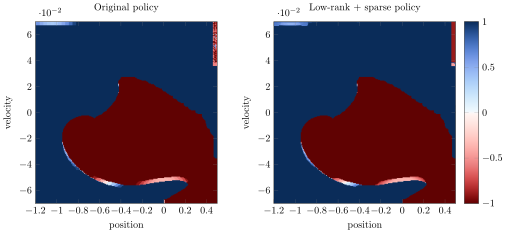

In [14]:
viz_policies(mdp_mc, pmc, pmc_lrm, mc.XMIN, mc.XMAX, mc.VMIN, mc.VMAX, 
             "position", "velocity", false)

###Visually compare inverted pendulum policies

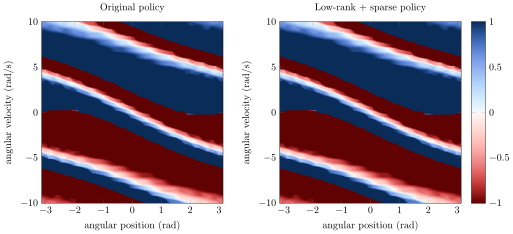

In [13]:
viz_policies(mdp_ip, pip, pip_lrm, ip.PMIN, ip.PMAX, ip.VMIN, ip.VMAX, 
             "angular position (rad)", "angular velocity (rad/s)", false)

###Compare mountain car simulations

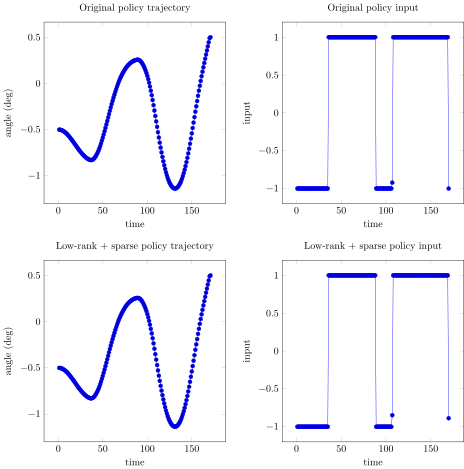

In [9]:
mc_ss, mc_as = mc.simulate(mdp_mc, pmc, [-0.5, 0.0])
mc_ss_lrm, mc_as_lrm = mc.simulate(mdp_mc, pmc_lrm, [-0.5, 0.0])
viz_trajectories(mc_ss, mc_as, mc_ss_lrm, mc_as_lrm, false)

###Compare inverted pendulum simulations

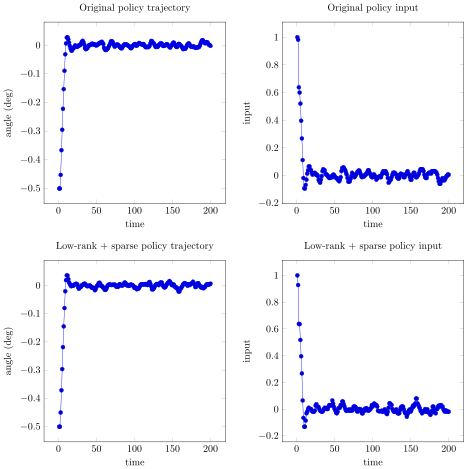

In [10]:
ip_ss, ip_as = ip.simulate(mdp_ip, pip, [-0.5, 0.0])
ip_ss_lrm, ip_as_lrm = ip.simulate(mdp_ip, pip_lrm, [-0.5, 0.0])
viz_trajectories(ip_ss, ip_as, ip_ss_lrm, ip_as_lrm, false)

###Run bulk mountain car simulations
Performance metric based on how long the car takes to reach the mountaintop.

In [11]:
nsim = 1000
times = zeros(2)
for sim = 1:nsim
    state = [rand(mc.XMIN:0.001 * (mc.XMAX - mc.XMIN):mc.XMAX), 
             rand(mc.VMIN:0.001 * (mc.VMAX - mc.VMIN):mc.VMAX)]
    _, as = mc.simulate(mdp_mc, pmc, copy(state))
    _, as_lrm = mc.simulate(mdp_mc, pmc_lrm, copy(state))
    times[1] += length(as)
    times[2] += length(as_lrm)
end # for sim
times /= nsim
@printf("average times\n\toriginal: %.3e\n\tlow-rank: %.3e", times[1], times[2])

average times
	original: 5.358e+01
	low-rank: 5.358e+01

###Run bulk inverted pendulum simulations
Performance metric based on how well the algorithm can keep the pendulum in the unstable equilibrium position.

In [12]:
nsim = 1000
deviation = zeros(2)
for sim = 1:nsim
    state = [rand(ip.PMIN:0.001 * (ip.PMAX - ip.PMIN):ip.PMAX), 
             rand(ip.VMIN:0.001 * (ip.VMAX - ip.VMIN):ip.VMAX)]
    traj, _ = ip.simulate(mdp_ip, pip, copy(state))
    traj_lrm, _ = ip.simulate(mdp_ip, pip_lrm, copy(state))
    deviation[1] += vecnorm(traj[51:end, 1])
    deviation[2] += vecnorm(traj_lrm[50:end, 1])
end # for sim
deviation /= nsim
@printf("average deviation\n\toriginal: %.3e\n\tlow-rank: %.3e", 
        deviation[1], deviation[2])

average deviation
	original: 6.132e-01
	low-rank: 6.194e-01